<a href="https://colab.research.google.com/github/bzhenka/DecisionTrees/blob/main/DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №5

Датасет с классификацией грибов

## Импорт данных

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

# metadata
print(mushroom.metadata)

# variable information
print(mushroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [ ]:
print(X.shape)
print(y.shape)

(8124, 22)
(8124, 1)


# Предворительная обработка данных

Обработка отсутствующих значений - заменяем nan

In [ ]:
X.isnull().sum()

,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0
stalk-shape,0


In [ ]:
X['stalk-root'].unique()

array(['e', 'c', 'b', 'r', nan], dtype=object)

Использование значения 'unknown' подразумевает, что отсутствующая информация рассматривается как отдельная категория.

In [ ]:
X.loc[:, 'stalk-root'] = X['stalk-root'].fillna('unknown')
X.isnull().sum()

,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0
stalk-shape,0


Статистика

Устанавливаем максимальное количество отображаемых столбцов равным количеству столбцов в X.

In [ ]:
pd.options.display.max_columns = X.shape[1]
X.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


## Отбор случайным образом  𝑠𝑞𝑟𝑡(𝑛)  признаков

In [ ]:
n = math.ceil(math.sqrt(len(X.columns))) # количество случайных признаков, которые будут выбраны
random_features = random.sample(list(X.columns), n)
filtered_X = X[random_features]
filtered_X.head()

,ring-number,stalk-shape,habitat,veil-type,cap-shape
0,o,e,u,p,x
1,o,e,g,p,x
2,o,e,m,p,b
3,o,e,u,p,x
4,o,t,g,p,x


Разделение на обучающий и тестовый наборы

In [ ]:
# Устанавливаем долю данных для обучения на уровне 80%
train_ratio = 0.8
# перемешивает строки DataFrame filtered_X случайным образом.
indices = np.random.permutation(len(filtered_X))

train_size = int(len(filtered_X) * train_ratio)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = filtered_X.iloc[train_indices], filtered_X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

## Реализация Дерева решений

Дерево решений используется для того, чтобы на основе входных данных (признаков) делать предсказания о целевой переменной

Энтропия — это мера неопределенности или разнообразия значений в данных.

Определить, какие признаки наиболее информативны для целевой переменной.

Как это работает:

- Чем ниже энтропия, тем меньше неопределенности.

- Признаки с низкой энтропией содержат меньше разнообразия и могут быть менее полезными.

- Признаки с высокой энтропией более вариативны и потенциально более полезны для классификации или предсказания.

$Info(T)=-\sum^{k}_{j=1}\frac{freq(C_j, T)}{|T|}\cdot log_2(\frac{freq(C_j, T)}{|T|})$

In [ ]:
def entropy(y):
  _, counts = np.unique(y, return_counts=True)

  prob = counts / len(y)
  return -np.sum(prob * np.log2(prob))

Считаем изменение энтропии (энтропия до - условная энтропия (степень неопределенности Y после установления случайной величины X))

$\text{Info}_x(T)=\sum^{n}_{i=1}(\frac{|T_i|}{|T|}\cdot \text{Info}(T_i))$

In [ ]:
def information_gain(X, y, feature_index):
  feature_values = X.iloc[:, feature_index]

  unique_values = np.unique(feature_values)

  entropy_before = entropy(y)

  weighted_entropy = 0

# Проходим по каждому уникальному значению признака
  for value in unique_values:
    # Выбираем подмножество меток y, где признак имеет значение 'value'
    subset_y = y[feature_values == value]
    weighted_entropy += len(subset_y) / len(y) * entropy(subset_y)

  return entropy_before - weighted_entropy

In [ ]:
def best_split(X, y):
    # Инициализируем переменные для хранения наилучшего прироста информации и соответствующего признака
    best_gain = -1  # Прирост информации, начинаем с очень маленького значения
    best_feature = -1  # Индекс признака, который дает лучший прирост информации

    # Проходим по всем признакам (столбцам) в X
    for i in range(X.shape[1]):
        # Вычисляем прирост информации для текущего признака (столбца)
        gain = information_gain(X, y, i)

        # Если прирост информации для текущего признака лучше, чем предыдущий лучший
        if gain > best_gain:
            # Обновляем наилучший прирост и соответствующий признак
            best_gain = gain
            best_feature = i

    # Возвращаем индекс признака, который дал наибольший прирост информации
    return best_feature

Строим дерево согласно алгоритму C4.5

Алгоритм выбирает на каждом шаге наилучший признак для разбиения данных, используя различные метрики для оценки качества разбиений.

In [ ]:
def build_tree(X, y, depth=0):
    # Если все метки в целевой переменной одинаковы, создаем листовое дерево с этой меткой
    if len(np.unique(y)) == 1:
        label = y.iloc[0]['poisonous']  # Определяем метку (класс)
        # Возвращаем узел с меткой и вероятностями для классов
        return {'label': label, 'probabilities': {label: 1.0, ('p' if label == 'e' else 'e'): 0.0}}

    # Если нет признаков для разделения (X.shape[1] == 0), возвращаем наиболее частую метку
    if X.shape[1] == 0:
        label = y['poisonous'].value_counts().idxmax()  # Определяем наиболее часто встречающийся класс
        total = len(y)  # Общее количество примеров в подмножестве
        # Считаем вероятности для каждого класса
        probabilities = y['poisonous'].value_counts(normalize=True).to_dict()
        return {'label': label, 'probabilities': probabilities}

    # Выбираем лучший признак для разбиения с помощью функции best_split
    best_feature = best_split(X, y)

    best_feature_name = X.columns[best_feature]  # Имя признака, который был выбран для разделения
    tree = {'feature': best_feature_name}  # Создаем узел дерева для выбранного признака

    # Получаем уникальные значения выбранного признака
    unique_values = np.unique(X.iloc[:, best_feature])
    subtrees = {}  # Словарь для хранения поддеревьев (разбиений)

    # Для каждого уникального значения признака создаем поддерево
    for value in unique_values:
        # Создаем подмножество данных для текущего значения признака
        subset_X = X[X.iloc[:, best_feature] == value].drop(columns=[best_feature_name])
        subset_y = y[X.iloc[:, best_feature] == value]

        # Рекурсивно строим поддерево для текущего значения признака
        subtrees[value] = build_tree(subset_X, subset_y, depth + 1)

    # Добавляем поддеревья в текущий узел
    tree['subtrees'] = subtrees
    return tree

In [ ]:
tree = build_tree(X_train, y_train)
print(tree)

{'feature': 'habitat', 'subtrees': {'d': {'feature': 'stalk-shape', 'subtrees': {'e': {'feature': 'ring-number', 'subtrees': {'n': {'label': 'p', 'probabilities': {'p': 1.0, 'e': 0.0}}, 'o': {'feature': 'cap-shape', 'subtrees': {'b': {'label': 'p', 'probabilities': {'p': 1.0, 'e': 0.0}}, 'f': {'feature': 'veil-type', 'subtrees': {'p': {'label': 'p', 'probabilities': {'p': 0.923469387755102, 'e': 0.07653061224489796}}}}, 'k': {'label': 'p', 'probabilities': {'p': 1.0, 'e': 0.0}}, 'x': {'feature': 'veil-type', 'subtrees': {'p': {'label': 'p', 'probabilities': {'p': 0.9508670520231214, 'e': 0.049132947976878616}}}}}}, 't': {'label': 'e', 'probabilities': {'e': 1.0, 'p': 0.0}}}}, 't': {'feature': 'cap-shape', 'subtrees': {'f': {'feature': 'ring-number', 'subtrees': {'o': {'feature': 'veil-type', 'subtrees': {'p': {'label': 'e', 'probabilities': {'e': 0.8308571428571428, 'p': 0.16914285714285715}}}}}}, 'k': {'label': 'p', 'probabilities': {'p': 1.0, 'e': 0.0}}, 'x': {'feature': 'ring-number

## Предсказание

Предсказание для одного набора параметров

In [ ]:
def predict(tree, X):
  if 'label' in tree:
    return tree['label']
  if X[tree['feature']].empty:
    return None
  feature_value = X[tree['feature']].iloc[0]
  subtree = tree['subtrees'].get(feature_value)

  return predict(subtree, X)

Предсказание для всех наборов параметров

In [ ]:
def predict_all(tree, X_test):
  predictions = pd.DataFrame({
    'poisonous': []
  })

  for i in range(X_test.shape[0]):
    prediction = predict(tree, X_test[i:i + 1])
    predictions.loc[X_test.index[i]] = {'poisonous': prediction}

  return predictions

## Оценка предсказаний с использованием Accuracy, Precision и Recall

Правильность $\text{Accuracy}=\frac{\text{TP}+\text{TN}}{N}$

Способность отличать этот класс от других $\text{Precision}=\frac{\text{TP}}{\text{TP}+\text{FP}}$

Способность обнаруживать данный класс, sensitivity $\text{Recall}=\frac{\text{TP}}{\text{TP}+\text{FN}}$

In [ ]:
def evaluate(y_true, y_pred):
    # Создаем отображение меток ('p' -> 1, 'e' -> 0) для перевода в числовые значения
    label_map = {'p': 1, 'e': 0}

    # Преобразуем целевые значения и предсказания в числовые метки (1 для 'p', 0 для 'e')
    y_true_numeric = [label_map[val] for val in y_true['poisonous']]
    y_pred_numeric = [label_map[val] for val in y_pred['poisonous']]

    # Инициализация счетчиков для различных типов ошибок
    TP = TN = FP = FN = 0  # True Positive, True Negative, False Positive, False Negative

    # Пройдемся по всем элементам в истинных и предсказанных метках и обновим счетчики
    for true, pred in zip(y_true_numeric, y_pred_numeric):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 1 and pred == 0:
            FN += 1


    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall}


In [ ]:
prediction = predict_all(tree, X_test)

In [ ]:
evaluate(y_test, prediction)

{'accuracy': 0.8713846153846154,
 'precision': 0.8929539295392954,
 'recall': 0.835234474017744}

## ROC


ROC (Receiver Operating Characteristic) — это график, который используется для оценки качества бинарной классификации. Он показывает соотношение между истинно положительными и ложно положительными результатами при разных порогах классификации.


PR (Precision-Recall) — это еще одна пара метрик, используемая для оценки качества классификации, особенно в задачах с несбалансированными классами. В отличие от ROC-кривой, которая учитывает как ложноположительные, так и истинноположительные результаты, PR-кривая фокусируется исключительно на положительном классе

In [ ]:
def predict_with_probabilities(tree, X):
    # Если в дереве есть уже рассчитанные вероятности (для листа), возвращаем их
    if 'probabilities' in tree:
        return tree['probabilities']

    # Если признак для текущего узла отсутствует в данных или он пустой, возвращаем равные вероятности
    if tree['feature'] not in X or X[tree['feature']].empty:
        return {'p': 0.5, 'e': 0.5}

    # Получаем значение признака для текущего примера
    feature_value = X[tree['feature']].iloc[0]

    # Получаем поддерево, соответствующее значению признака
    subtree = tree['subtrees'].get(feature_value)

    # Если поддерево отсутствует, возвращаем равные вероятности
    if subtree is None:
        return {'p': 0.5, 'e': 0.5}

    # Рекурсивно вызываем функцию для следующего уровня дерева
    return predict_with_probabilities(subtree, X)

In [ ]:
def predict_all_probabilities(tree, X_test):
    y_pred_prob = []  # Список для хранения предсказанных вероятностей для каждого примера

    # Проходим по всем строкам в X_test
    for i in range(X_test.shape[0]):
        # Для каждого примера получаем вероятности с помощью функции predict_with_probabilities
        probabilities = predict_with_probabilities(tree, X_test[i:i + 1])

        # Добавляем вероятность для класса 'p' в список
        y_pred_prob.append(probabilities['p'])

    # Возвращаем список вероятностей для класса 'p'
    return y_pred_prob

In [ ]:
def compute_metrics(y_true, y_pred_prob):
    # Сортируем вероятности для вычисления порогов классификации (обратный порядок)
    thresholds = [sorted(set(y_pred_prob), reverse=True)][0]

    roc_points = []
    pr_points = []

    # Добавляем начальные точки для ROC и PR кривых (при пороге 0)
    roc_points.append((0, 0))
    pr_points.append((0, 1))

    # Преобразуем метки классов в числовые значения (1 для 'p' и 0 для 'e')
    label_map = {'p': 1, 'e': 0}
    y_true_numeric = [label_map[val] for val in y_true['poisonous']]

    # Проходим по всем возможным порогам
    for threshold in thresholds:
        # Классифицируем на основе порога: если вероятность >= порог, то класс 1 (положительный), иначе 0
        y_pred_binary = [(1 if prob >= threshold else 0) for prob in y_pred_prob]

        # Вычисляем TP, TN, FP, FN для данного порога
        TP = sum(1 for true, pred in zip(y_true_numeric, y_pred_binary) if true == 1 and pred == 1)
        TN = sum(1 for true, pred in zip(y_true_numeric, y_pred_binary) if true == 0 and pred == 0)
        FP = sum(1 for true, pred in zip(y_true_numeric, y_pred_binary) if true == 0 and pred == 1)
        FN = sum(1 for true, pred in zip(y_true_numeric, y_pred_binary) if true == 1 and pred == 0)

        # Вычисляем метрики для ROC (TPR и FPR) и PR (Precision и Recall)
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate (Recall)
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
        Precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision
        Recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall

        # Добавляем текущие точки в списки для ROC и PR кривых
        roc_points.append((FPR, TPR))
        pr_points.append((Recall, Precision))

    # Добавляем конечные точки для ROC и PR кривых (при пороге 1)
    roc_points.append((1, 1))
    pr_points.append((1, 0))

    return roc_points, pr_points


In [ ]:
def plot_auc_curves(roc_points, pr_points):
  # AUC-ROC Curve
  # roc_points = sorted(roc_points)
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
  plt.plot([x[0] for x in roc_points], [x[1] for x in roc_points], marker='o', label='ROC')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('AUC-ROC Curve')
  plt.legend()

  # AUC-PR Curve
  # pr_points = sorted(pr_points, reverse=True)
  plt.subplot(1, 2, 2)
  plt.plot([0, 1], [1, 0], 'k--', label='Random Guess')
  plt.plot([x[0] for x in pr_points], [x[1] for x in pr_points], marker='o', label='PR')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('AUC-PR Curve')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def calculate_auc(points):
  auc = 0
  for i in range(1, len(points)):
    x1, y1 = points[i - 1]
    x2, y2 = points[i]
    auc += (x2 - x1) * (y1 + y2) / 2
  return auc

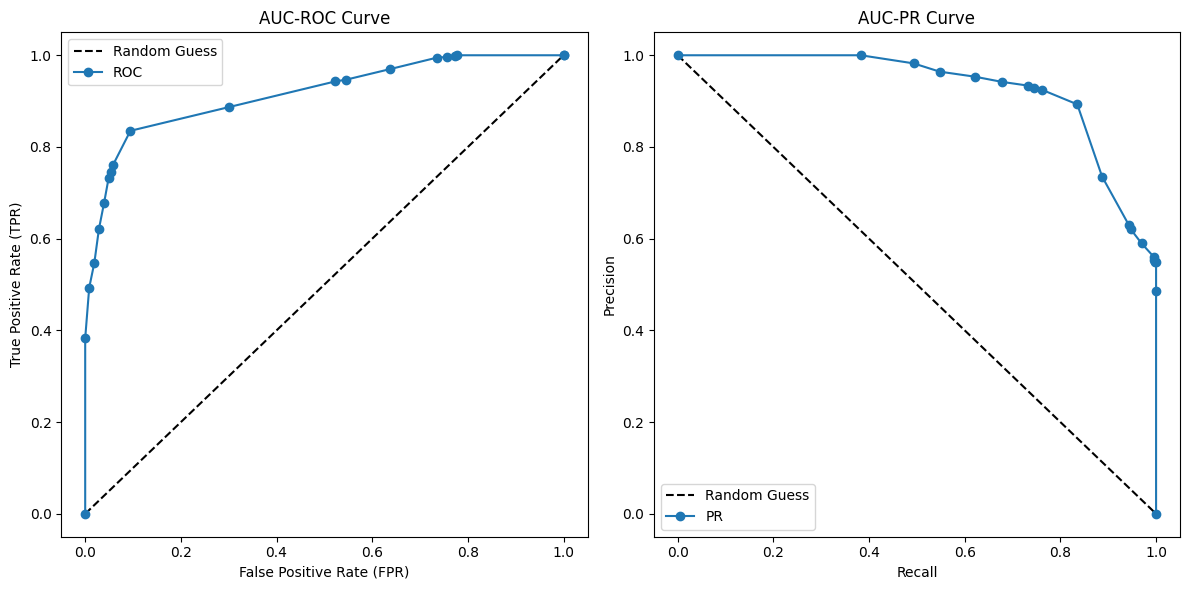

AUC-ROC: 0.915
AUC-PR: 0.929


In [ ]:
y_pred_prob = predict_all_probabilities(tree, X_test)
roc_points, pr_points = compute_metrics(y_test, y_pred_prob)

plot_auc_curves(roc_points, pr_points)

auc_roc = calculate_auc(roc_points)
auc_pr = calculate_auc(pr_points)

print(f"AUC-ROC: {auc_roc:.3f}")
print(f"AUC-PR: {auc_pr:.3f}")

По мере продвижения по ROC-кривой в направлении вправо и вверх, мы увеличиваем TPR (долю правильно классифицированных ядовитых грибов), однако это также приводит к увеличению FPR (доли съедобных грибов, ошибочно классифицированных как ядовитые).

Когда мы двигаемся по PR-кривой вправо и вниз, точность (Precision) уменьшается, так как доля ядовитых грибов среди всех классифицированных как ядовитые становится ниже, но при этом Recall (полнота) возрастает, поскольку удается находить больше ядовитых грибов.